In [3]:
import pandas as pd 
import numpy as np
import pickle
from collections import defaultdict
import tensorflow as tf

def read_file(filename):
  with open(filename, "rb") as file:
      stat = pickle.load(file)
      file.close()
  return stat

def get_origin_path(stat):
    path_link = stat['data']['paths_link']
    od = [k for k in path_link.keys()]
    path1 = [tuple(p[0]) if len(p) > 0 else np.nan for p in path_link.values()]
    path2 = [tuple(p[1]) if len(p) > 1 else np.nan for p in path_link.values()]
    path3 = [tuple(p[2]) if len(p) > 2 else np.nan for p in path_link.values()]

    demand_dic = stat["data"]["demand"]
    demand = [v for v in demand_dic.values()]
    path_link_df = pd.DataFrame({"od": od, "demand":demand, "path1": path1, "path2": path2, "path3": path3})
    return path_link_df

def get_UE_link_cost(stat):
    # return a dataframe of link cost, link flow
    link = stat['data']['network'].copy()
    link['link_flow'] = stat['link_flow']
    # Calculate link cost
    link['link_cost'] = round(link['free_flow_time']*\
                            (1+link['b']*((link['link_flow']/link['capacity'])**4)), 2)
    return link

# Calculate path travel time for each od pair
def calculate_path_cost(row, link_df):
    if pd.isna(row): 
        return np.nan
    
    sum_time = 0
    for l in row:
        sum_time += link_df.at[l, 'link_cost']
    return round(sum_time, 2)

# calculate each link flow based on path flow
def extract_link_flow(path_link, flows):
    # input: a dictionary of {od pair: path_link} and list of flow distribution
    # return a dictionary of link flow
    path_flow = {}
    for path_set, flow_set in zip(path_link.values(), flows):
        for path, flow in zip(path_set, flow_set):
            path_flow[tuple(path)] = flow

    aggregated_sums = defaultdict(float)
    for path, flow in path_flow.items():
        for link in path:
            aggregated_sums[link] += flow
    link_flow = dict(aggregated_sums)
    return link_flow

In [4]:
# Check UE of origin dataset 
def mean_path_cost(filename):
    stat = read_file(filename)
    path_link_df = get_origin_path(stat)
    UE_link = get_UE_link_cost(stat)

    path_link_df['path1_cost'] = path_link_df['path1'].apply(lambda x: calculate_path_cost(x, UE_link))
    path_link_df['path2_cost'] = path_link_df['path2'].apply(lambda x: calculate_path_cost(x, UE_link))
    path_link_df['path3_cost'] = path_link_df['path3'].apply(lambda x: calculate_path_cost(x, UE_link))

    flows = stat['path_flow']
    path_link_df['flow1'] = [f[0] if len(f)>0 else 0 for f in flows]
    path_link_df['flow2'] = [f[1] if len(f)>1 else 0 for f in flows]
    path_link_df['flow3'] = [f[2] if len(f)>2 else 0 for f in flows]

    mean_path_cost = (np.nanmean(path_link_df['path1_cost']) + np.nanmean(path_link_df['path2_cost']) + np.nanmean(path_link_df['path3_cost']))/3
    return UE_link, path_link_df, mean_path_cost

def sum_pred_link_flow(pred_df, stat):
    pred_path_flow = pred_df[['flow1', 'flow2', 'flow3']].values.tolist()
    path_link = stat['data']['paths_link']

    pred_link_flow = extract_link_flow(path_link, pred_path_flow)
    pred_link_flow = pd.DataFrame.from_dict(pred_link_flow, orient='index', columns=['link_flow']).sort_index(ascending=True).reset_index()
    pred_link_flow.rename(columns={'index': 'link_id'}, inplace=True)
    link = stat['data']['network'].copy()[['link_id', 'capacity', 'free_flow_time', 'b']]
    output = pd.merge(link, pred_link_flow, how='left', on='link_id')
    output = output.fillna(0)
    output['link_cost'] = round(output['free_flow_time']*\
                            (1+output['b']*((output['link_flow']/output['capacity'])**4)), 2)
    return output

def calculate_delay(pred_df, pred_link_flow):
    pred_df['path1_cost'] = pred_df['path1'].apply(lambda x: calculate_path_cost(x, pred_link_flow))
    pred_df['path2_cost'] = pred_df['path2'].apply(lambda x: calculate_path_cost(x, pred_link_flow))
    pred_df['path3_cost'] = pred_df['path3'].apply(lambda x: calculate_path_cost(x, pred_link_flow))
    pred_df['min_path_cost'] = pred_df[['path1_cost', 'path2_cost', 'path3_cost']].min(axis=1)
    pred_df['delay'] = (
        pred_df['flow1'] * (pred_df['path1_cost'] - pred_df['min_path_cost']) +
        pred_df['flow2'] * (pred_df['path2_cost'] - pred_df['min_path_cost']) +
        pred_df['flow3'] * (pred_df['path3_cost'] - pred_df['min_path_cost'])
    )
    avg_delay = pred_df['delay'].sum()/pred_df['demand'].sum()
    #return average delay in minutes
    return avg_delay*60
# path_link_df.head()

In [25]:
demand = []
od_pair = []
size = 1
for i in tqdm(range(size)):
    filename = f"../Output/5by5_Data{i}"
    stat = read_file(filename)
    demand_dic = stat["data"]["demand"]
    demand.append(v for v in demand_dic.values())
    od_pair.append(len(demand_dic.keys()))
demand = [i for j in demand for i in j]
# len(demand)
len(od_pair)

100%|██████████| 40000/40000 [04:30<00:00, 148.04it/s]


40000

/Users/viviane/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/viviane/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/viviane/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/viviane/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf va

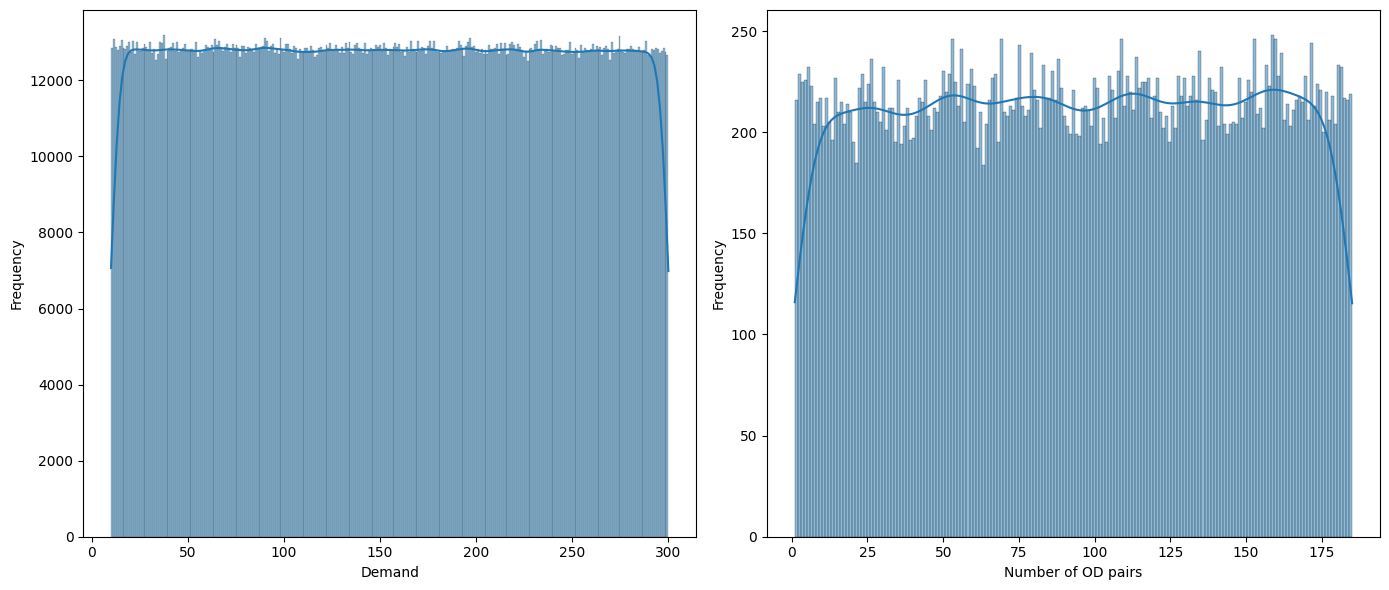

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 6))

plt.subplot(1,2, 1)
sns.histplot(demand, bins=300-10+1, kde=True)
plt.xlabel('Demand')
plt.ylabel('Frequency')

plt.subplot(1,2, 2)
sns.histplot(od_pair, bins=np.max(od_pair)-np.min(od_pair)+1, kde=True)
# sns.histplot(od_pair, bins=200, kde=True)
plt.xlabel('Number of OD pairs')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [38]:
filename = '../Output/5by5_Data0'
stat = read_file(filename)

,od,demand,path1,path2,path3,path1_cost,path2_cost,path3_cost,flow1,flow2,flow3
0,"(1, 25)",161,"(0, 4, 15, 18, 23, 38, 42, 60)","(1, 14, 26, 30, 34, 38, 42, 60)","(0, 4, 17, 30, 34, 38, 42, 60)",6.31,6.34,6.33,0.0,118.0,43.0
1,"(7, 20)",111,"(15, 18, 23, 38, 42)","(17, 30, 34, 38, 42)","(15, 20, 34, 38, 42)",4.38,4.40,4.40,111.0,0.0,0.0
2,"(1, 22)",14,"(0, 4, 17, 32, 50)","(1, 14, 26, 32, 50)","(1, 14, 28, 44, 50)",3.33,3.34,3.08,0.0,0.0,14.0
3,"(7, 18)",114,"(15, 20, 36)","(17, 30, 36)","(17, 32, 48)",2.27,2.27,2.02,0.0,0.0,114.0
4,"(4, 20)",42,"(10, 23, 38, 42)","(10, 23, 40, 56)","(6, 7, 18, 23, 38, 42)",3.39,2.71,4.86,0.0,42.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
94,"(8, 24)",147,"(18, 23, 40, 58)","(20, 34, 40, 58)","(20, 36, 52, 58)",2.89,2.91,2.67,0.0,0.0,147.0
95,"(3, 15)",265,"(7, 18, 23, 38)","(7, 20, 34, 38)","(3, 4, 15, 18, 23, 38)",3.66,3.68,5.12,265.0,0.0,0.0
96,"(11, 25)",159,"(26, 30, 34, 38, 42, 60)","(28, 44, 48, 52, 56, 60)","(26, 30, 36, 52, 56, 60)",5.07,3.64,4.15,0.0,159.0,0.0
97,"(3, 5)",167,"(7, 18, 23, 38, 25, 12)","(7, 20, 34, 38, 25, 12)","(7, 16, 17, 30, 34, 38, 25, 12)",4.94,4.96,6.43,33.0,134.0,0.0


In [6]:
# Average path cost
from tqdm import tqdm

sum_avg = 0
size = 300

for i in tqdm(range(size)):
    file_name = f"../Output2/5by5_Data{i}"
    UE_link, df, mean_cost = mean_path_cost(file_name)
    # df.head()

    delay = calculate_delay(df, UE_link)
    sum_avg+=delay
delay = sum_avg/size
print("Delay: ", delay*60, " seconds")

100%|██████████| 300/300 [00:07<00:00, 39.05it/s]


Read predicted output

In [4]:
def load_from_file(filename):
    with open(filename, 'r') as f:
        data = np.loadtxt(f)
    num_tensors = data.size // (3 * 625)
    reshaped_data = data.reshape((num_tensors, 3, 625))
    tensors = [tf.convert_to_tensor(reshaped_data[i], dtype=tf.float32) for i in range(num_tensors)]
    return tensors

predicted_values = load_from_file('../predicted_result.txt')
print(len(predicted_values))

10


In [23]:
def extract_flow(tensor):
  # input: a single tensor of predicted path flow
  # return a dictionary of full information: od pair,predicted path flow
  final_dict = {}
  for sub_flow_index, sub_flow in enumerate(tensor):
    sub_flow_dict = {(i+1, j+1): int(sub_flow[i, j]) for i in range(sub_flow.shape[0]) for j in range(sub_flow.shape[1])}

    for key, value in sub_flow_dict.items():
        if key not in final_dict:
            final_dict[key] = [None] * tensor.shape[0]
        final_dict[key][sub_flow_index] = value
  final_dict = {k: v for k, v in final_dict.items() if not all(val == 0 for val in v)}
  return final_dict

def create_pred_df(tensor, stat):
  final_dict = extract_flow(tensor)
  print("Number of OD pairs predicted: ", len(final_dict))
  print("Number of origin OD pairs: ", len(stat['path_flow']))
  
  flow_df = pd.DataFrame.from_dict(final_dict, orient='index', columns=['pred_f1', 'pred_f2', 'pred_f3']).reset_index()
  flow_df.rename(columns={'index': 'od'}, inplace=True)
  pred_df = get_origin_path(stat)[['od', 'demand', 'path1', 'path2', 'path3']]
  pred_df = pd.merge(pred_df, flow_df, how='left', on='od')
  nan_val = pred_df['pred_f1'].isna().sum()
  # Percentage of nan value
  print("Nan values: ", nan_val, " -- ", round(nan_val/len(stat['path_flow'])*100,2), "%")
  pred_df = pred_df.fillna(0)
  return pred_df

# Calculate link flow from pred path flow
def sum_pred_link_flow(pred_df, stat):
    pred_path_flow = pred_df[['pred_f1', 'pred_f2', 'pred_f3']].values.tolist()
    path_link = stat['data']['paths_link']

    pred_link_flow = extract_link_flow(path_link, pred_path_flow)
    pred_link_flow = pd.DataFrame.from_dict(pred_link_flow, orient='index', columns=['pred_link_flow']).sort_index(ascending=True).reset_index()
    pred_link_flow.rename(columns={'index': 'link_id'}, inplace=True)
    link = stat['data']['network'].copy()[['link_id', 'capacity', 'free_flow_time', 'b']]
    output = pd.merge(link, pred_link_flow, how='left', on='link_id')
    output = output.fillna(0)
    output['link_cost'] = round(output['free_flow_time']*\
                            (1+output['b']*((output['pred_link_flow']/output['capacity'])**1)), 2)
    return output

def calculate_delay(pred_df, pred_link_flow):
    pred_df['path1_cost'] = pred_df['path1'].apply(lambda x: calculate_path_cost(x, pred_link_flow))
    pred_df['path2_cost'] = pred_df['path2'].apply(lambda x: calculate_path_cost(x, pred_link_flow))
    pred_df['path3_cost'] = pred_df['path3'].apply(lambda x: calculate_path_cost(x, pred_link_flow))
    pred_df['min_path_cost'] = pred_df[['path1_cost', 'path2_cost', 'path3_cost']].min(axis=1)
    pred_df['delay'] = (
        pred_df['pred_f1'] * (pred_df['path1_cost'] - pred_df['min_path_cost']) +
        pred_df['pred_f2'] * (pred_df['path2_cost'] - pred_df['min_path_cost']) +
        pred_df['pred_f3'] * (pred_df['path3_cost'] - pred_df['min_path_cost'])
    )
    avg_delay = pred_df['delay'].sum()/pred_df['demand'].sum()
    #return average delay in minutes
    return avg_delay*60

def single_avg_delay(pred_tensor, filename):
    stat = read_file(filename)
    a = tf.reshape(pred_tensor, (3, 25, 25))
    pred_df = create_pred_df(a, stat)
    pred_link_flow = sum_pred_link_flow(pred_df, stat)
    avg_delay = calculate_delay(pred_df, pred_link_flow)
    return avg_delay

In [30]:
%run ../parameters.py
p = Params()

# Check number of OD pair in origin dataset 
start_from=1800
files = []
for i in range(10):
    file_name = ''.join([p.base_path, str(start_from+i)])
    files.append(file_name)
    

In [31]:
# Check len of predicted path flow distribution
filename = '../Output/5by5_Data1800'

sum_delay = 0
for i, filename in zip(predicted_values, files):
    avg_delay = single_avg_delay(i, filename)
    sum_delay += avg_delay
    print(f"Average delay: {round(avg_delay,3)} mins")
    print("-----------------------------")
print("avg delay of prediction: ", sum_delay/len(predicted_values))

Number of OD pairs predicted:  322
Number of origin OD pairs:  127
Nan values:  54  --  42.52 %
Average delay: 3.817 mins
-----------------------------
Number of OD pairs predicted:  317
Number of origin OD pairs:  127
Nan values:  54  --  42.52 %
Average delay: 4.133 mins
-----------------------------
Number of OD pairs predicted:  311
Number of origin OD pairs:  127
Nan values:  51  --  40.16 %
Average delay: 1.65 mins
-----------------------------
Number of OD pairs predicted:  315
Number of origin OD pairs:  127
Nan values:  54  --  42.52 %
Average delay: 3.999 mins
-----------------------------
Number of OD pairs predicted:  318
Number of origin OD pairs:  127
Nan values:  58  --  45.67 %
Average delay: 3.455 mins
-----------------------------
Number of OD pairs predicted:  317
Number of origin OD pairs:  127
Nan values:  60  --  47.24 %
Average delay: 3.42 mins
-----------------------------
Number of OD pairs predicted:  322
Number of origin OD pairs:  127
Nan values:  43  --  33